In [10]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from pycocotools import mask
from PIL import Image, ImageDraw
from tqdm import tqdm
import json



In [4]:
LOCALIZATION_TASKS = [
    "Enlarged Cardiomediastinum",
    "Cardiomegaly",
    "Lung Lesion",
    "Airspace Opacity",
    "Edema",
    "Consolidation",
    "Atelectasis",
    "Pneumothorax",
    "Pleural Effusion",
    "Support Devices",
]

In [15]:
def create_mask(polygons, img_dims):
    """
    Creates a binary mask (of the original matrix size) given a list of polygon
        annotations format.

    Args:
        polygons (list): [[[x11,y11],[x12,y12],...[x1n,y1n]],...]

    Returns:
        mask (np.array): binary mask, 1 where the pixel is predicted to be the,
                                                 pathology, 0 otherwise
    """
    poly = Image.new("1", (img_dims[1], img_dims[0]))
    for polygon in polygons:
        coords = [(point[0], point[1]) for point in polygon]
        ImageDraw.Draw(poly).polygon(coords, outline=1, fill=1)

    binary_mask = np.array(poly, dtype="int")
    return binary_mask


def ann_to_mask(input_path, output_path):
    """
    Args:
        input_path (string): json file path with raw human annotations
        output_path (string): json file path for saving segmentation masks
    """
    print(f"Reading annotations from {input_path}...")
    with open(input_path) as f:
        ann = json.load(f)

    print(f"Creating and encoding segmentations...")
    for img_id in tqdm(ann.keys()):
        for task in LOCALIZATION_TASKS:
            if task in ann[img_id].keys():
                task_dir = os.path.join(output_path, task.lower().replace(" ", "_"))
                os.makedirs(task_dir, exist_ok=True)
                # create segmentation
                polygons = ann[img_id][task] if task in ann[img_id] else []
                img_dims = ann[img_id]["img_size"]
                segm_map = create_mask(polygons, img_dims)
                segm_map = np.array(segm_map, dtype=np.uint8)
                segm_map[segm_map == 1] = 255
                outfile = os.path.join(task_dir, img_id + ".png")
                cv2.imwrite(outfile, segm_map)

In [16]:
img_mask = ann_to_mask(
    "/mnt/Enterprise/PUBLIC_DATASETS/chexlocalize/CheXlocalize/gt_annotations_val.json",
    "/mnt/Enterprise/safal/VLM-SEG-2023/chexlocalize/val_masks",
)

Reading annotations from /mnt/Enterprise/PUBLIC_DATASETS/chexlocalize/CheXlocalize/gt_annotations_val.json...
Creating and encoding segmentations...


100%|██████████| 187/187 [00:22<00:00,  8.34it/s]


In [22]:
img_mask_np = np.array(img_mask)

In [25]:
np.unique(img_mask_np)

array([0, 1])

In [27]:
img_mask_np.shape

(2320, 2828)

In [30]:
# save the mask 0,255

img_mask_np[img_mask_np == 1] = 255

cv2.imwrite("mask.png", img_mask_np)

True

In [26]:
img = "/mnt/Enterprise/PUBLIC_DATASETS/chexlocalize/CheXpert/val/patient64541/study1/view1_frontal.jpg"
mask = "/mnt/Enterprise/safal/VLM-SEG-2023/chexlocalize/val_masks/patient64541_study1_view1_frontal_Enlarged_Cardiomediastinum.png"

In [27]:
# read image and mask
img = cv2.imread(img)
mask = cv2.imread(mask)

In [28]:
img.shape, mask.shape

((2320, 2828, 3), (2320, 2828, 3))

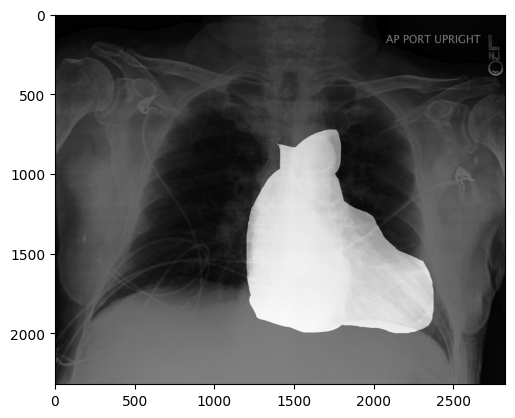

In [30]:
# plot image and mask over it
plt.imshow(img)
plt.imshow(mask, alpha=0.5, cmap="gray");